# 1. Setup and Load Data

### 1.1 Install Dependencies and Setup

In [1]:
!pip install tensorflow opencv-python matplotlib tensorflowjs

In [2]:
!pip list

Package                       Version
----------------------------- --------------------
absl-py                       1.4.0
alabaster                     0.7.12
anaconda-client               1.11.0
anaconda-navigator            2.3.2
anaconda-project              0.11.1
anyio                         3.5.0
appdirs                       1.4.4
applaunchservices             0.3.0
appnope                       0.1.2
appscript                     1.1.2
argon2-cffi                   21.3.0
argon2-cffi-bindings          21.2.0
arrow                         1.2.2
astroid                       2.11.7
astropy                       5.1
astunparse                    1.6.3
atomicwrites                  1.4.0
attrs                         21.4.0
Automat                       20.2.0
autopep8                      1.6.0
Babel                         2.9.1
backcall                      0.2.0
backports.functools-lru-cache 1.6.4
backports.tempfile            1.0
backports.weakref             1.0.post1
bcr

In [3]:
import tensorflow as tf
import os

2023-03-09 18:05:43.160531: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_grwoth(gpu, True)

                                                    

### 1.2 Remove invalid images

In [6]:
import cv2
import imghdr
from matplotlib import pyplot as plt

In [7]:
data_dir = 'dataset/training_set'

In [8]:
image_exts = ['jpg', 'jpeg', 'bmp', 'png']

In [9]:
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
            print('Issue with image {}'.format(image_path))

### 1.3 Load Data

In [10]:
import numpy as np
from matplotlib import pyplot as plt

In [11]:
data = tf.keras.utils.image_dataset_from_directory('dataset/training_set')

Found 1219 files belonging to 2 classes.


In [12]:
data_iterator = data.as_numpy_iterator()

In [13]:
batch = data_iterator.next()

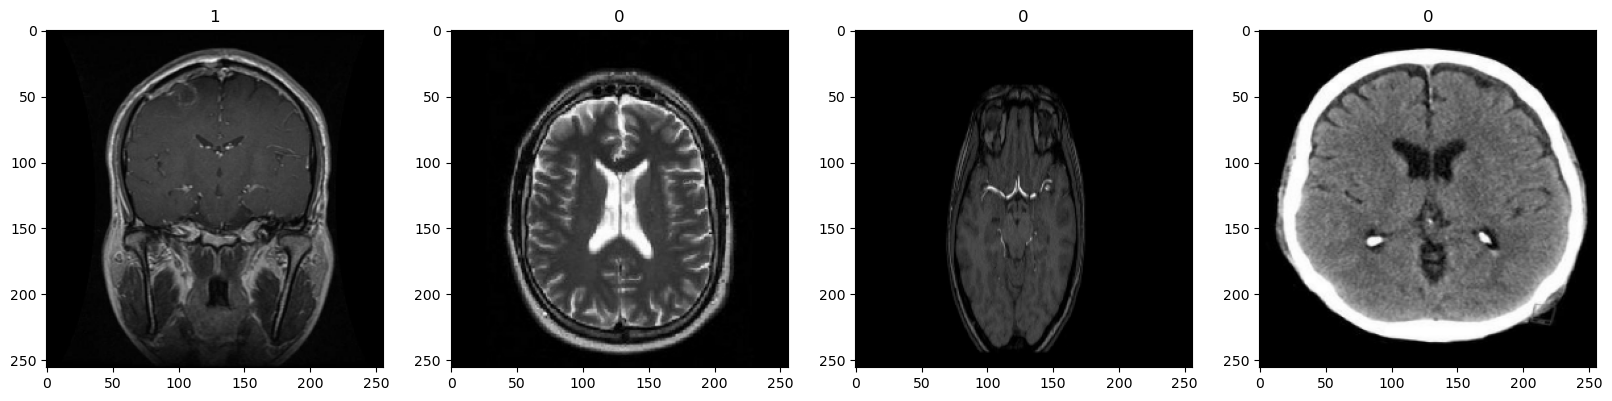

In [14]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [15]:
#Class 1 = tumor
#Class 0 = no tumor

# 2. Preprocess Data

### 2.1 Scale Data

In [16]:
data = data.map(lambda x, y: (x/255, y))

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [17]:
scaled_iterator = data.as_numpy_iterator()

In [18]:
batch = scaled_iterator.next()

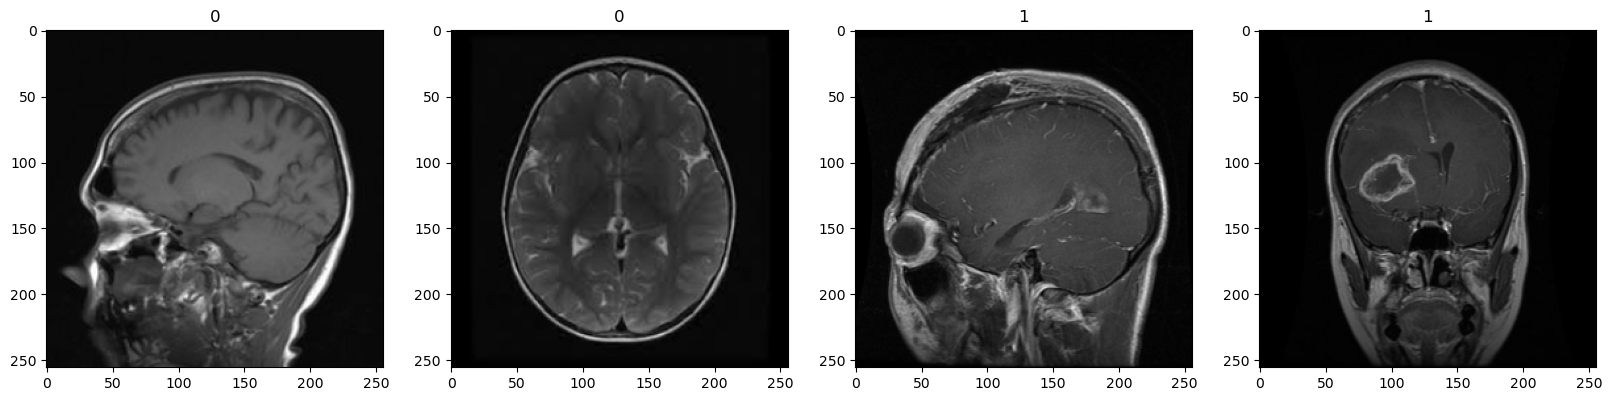

In [19]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

In [20]:
### 2.2 Split Data

In [21]:
train_size = int(len(data)*.7)
val_size = int(len(data)*0.2) + 1
test_size = int(len(data)*0.1) + 1

In [22]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size + val_size).take(test_size)

# 3. Deep Model

### 3.1 Build Deep Learning Model

In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [24]:
model = Sequential()

In [25]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256, 256, 3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [26]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 16)       0

### 3.2 Train

In [28]:
logdir='logs'

In [29]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [30]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
27/27 [==============================] - 18s 625ms/step - loss: 0.5159 - accuracy: 0.7847 - val_loss: 0.3260 - val_accuracy: 0.8945
Epoch 2/20
27/27 [==============================] - 17s 634ms/step - loss: 0.2314 - accuracy: 0.9271 - val_loss: 0.1919 - val_accuracy: 0.9375
Epoch 3/20
27/27 [==============================] - 18s 638ms/step - loss: 0.1242 - accuracy: 0.9572 - val_loss: 0.0900 - val_accuracy: 0.9727
Epoch 4/20
27/27 [==============================] - 18s 661ms/step - loss: 0.0756 - accuracy: 0.9757 - val_loss: 0.0506 - val_accuracy: 0.9844
Epoch 5/20
27/27 [==============================] - 23s 856ms/step - loss: 0.0295 - accuracy: 0.9942 - val_loss: 0.0410 - val_accuracy: 0.9766
Epoch 6/20
27/27 [==============================] - 25s 921ms/step - loss: 0.0252 - accuracy: 0.9954 - val_loss: 0.0174 - val_accuracy: 0.9922
Epoch 7/20
27/27 [==============================] - 24s 866ms/step - loss: 0.0077 - accuracy: 0.9988 - val_loss: 0.0219 - val_accuracy: 0.9922

### 3.3 Plot Performance

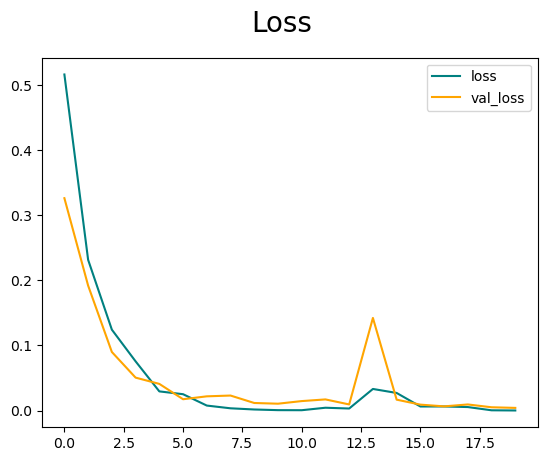

In [31]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper right")
plt.show()

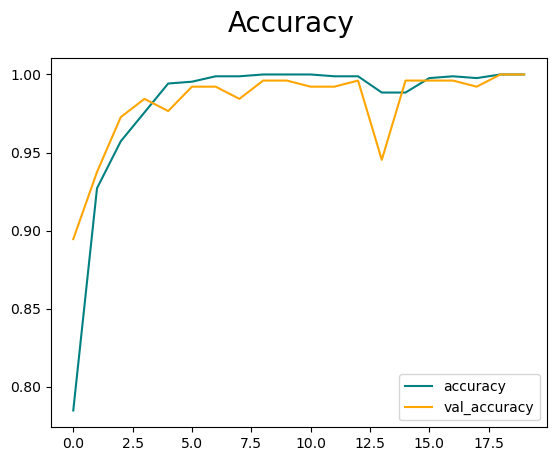

In [32]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="lower right")
plt.show()

#  4. Evaluate Performance

### 4.1 Evaluate

In [33]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [34]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [35]:
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 127ms/step


In [36]:
print(f'Precision:{pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

Precision:1.0, Recall:1.0, Accuracy:1.0


### 4.2 Test

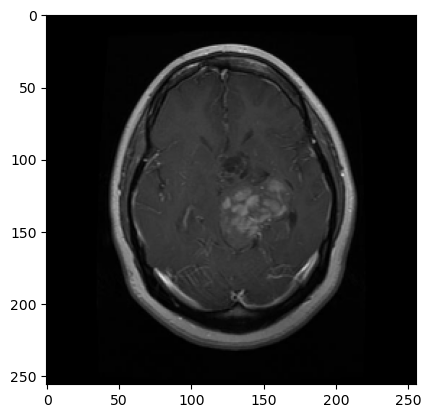

In [45]:
img = cv2.imread('dataset/single_prediction/2.jpg')
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [46]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 28ms/step


In [47]:
if yhat > 0.5:
    print(f'Predicted class is: tumor')
else:
    print(f)

Predicted class is: tumor


# 5. Save the Model

### 5.1 Save the Model

In [82]:
from tensorflow.keras.models import load_model

In [83]:
model.save(os.path.join('models', 'tumor-cnn-model.h5'));

In [84]:
new_model = load_model(os.path.join('models', 'tumor-cnn-model.h5'));

### 5.2 Convert the Model to TensorFlow.js

In [85]:
import tensorflowjs as tfjs

In [86]:
tfjs.converters.save_keras_model(model, 'models')